## A pure python neural network model of reflex conditioning in animal. 

need to add instructions on

install bleeding edge lasagne & theano
are we to assume that if they can open the notebook they are good?

This model uses the following packages:
* [Lasagne](http://lasagne.readthedocs.io/en/stable/index.html) :: A neural network framework built on Theano
* [Numpy](http://www.numpy.org/) :: Scientific computing packaging
* [Pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) :: Data manipulation, munging, formatting library
* [Theano](http://www.deeplearning.net/software/theano/) :: Deep learning framework
* [Matplotlib.pyplot](https://matplotlib.org/api/pyplot_api.html) :: Visualization

Begin by importing the necessary packages

In [1]:
import lasagne
import theano
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import theano.tensor as T

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\adam\docume~1\python~1\projects\nn_pro~1\nn_proj\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


*Note: If a warning DEPRACATED populates, set a USER variable defined as THEANO_FLAGS to an empty string.* 

Define constansts for the model

In [2]:
# ######################## Define Constants #################################
N_CS = 5
N_CONTEXT = 10
N_SAMPLES = 25
N_BATCHES = 250
N_SIMS = 20
output_file = 'output.xlsx'

The below function builds the dataset or input vector.  The dataset is a 2-dimensional binary array consisting of an initial 5 element CS, or *conditioned stimulus* portion and a 10 element context portion.  The length of each piece, and thus the dataset, is controlled using constants defined above. The `cs[rand_num][0] = 1.0` portion sets the value of the 1st element of a random vector within the array to 1, this correlates to *stimulus present*.

In [3]:
def build_dataset(n_cs=N_CS, n_context=N_CONTEXT, n_samples=N_SAMPLES):
    # build out cs portion of input var
    cs = [[0 for i in range(n_cs)] for j in range(n_samples)]
    rand_num = np.random.randint(0, high=len(cs))
    cs[rand_num][0] = 1.0

    # build out context portion of input var
    context = [float(np.random.randint(0, high=2)) for i in range(n_context)]

    # build input var
    input_var = []
    for array_item in cs:
        input_var.append(array_item + context)
    return np.asarray(input_var)

Next, defining a function to build targets for a loss function within the model.  The previously built dataset is used a reference point when building the targets to mitigate any errors while running the loss function.  The `cs_index = targets.index(1.)` saves the index of the *stimulus present* vector within the larger dataset array for use in later parts of the application. 

In [4]:
def build_targets(input_var):
    targets = []
    for item in input_var:
        if np.any(item[0] == 1.0):
            targets.append(1.0)
        else:
            targets.append(0.0)
    cs_index = targets.index( 1.)
    return np.asarray(targets), cs_index

On to building the network...

I choose to use lasagne library because of its restraint in abstracting away all of the lower level theano functionality.  Within the context of the experiment, it was not only important to see the activations and weights at the layer level, but also to be able to grab and manipulate them.  Other popular neural net libraries do not provide this acccess out of the box.   

Because the cortical network has 2 different training points, i.e. the *lower layer* weights with the hippocampal hidden layer activations, and the *upper layer* weights with the targets data outlined above; each piece of the cortical network had to built separately. This initial function defines the architecture of the lower cortical network.

In [5]:
# ################## Build Lower Cortical Network #############################
def build_cort_low_net(input_var=None):
    l_input = lasagne.layers.InputLayer(shape=(None, 15),
                                        input_var=input_var)
    l_output = lasagne.layers.DenseLayer(
                l_input,
                num_units=40,
                W=lasagne.init.Uniform(range=3.0),
                nonlinearity=lasagne.nonlinearities.rectify)
    return l_output

This network consists of an **Input Layer** accepting a dataset of shape `(None, 15)` where the *None* parameter indicates the size of that dimension is not fixed.  This is followed by a fully connected **Dense Layer** with 40 nodes and a *rectify* activation function.  The weights matrix values are initialized as a random number between *-3 and 3* using [init.Uniform](https://lasagne.readthedocs.io/en/latest/modules/init.html#lasagne.init.Uniform) method.  

The upper cortical network is defined with similar layers to the lower cortical network with the following differences.
1. The **Input Layer** accepts input with shape `(None, 40`) matching the output of the lower cortical network
2. The **Dense Layer** consists of a single node, matching the desired network output
3. A *sigmoid* activation function is used. 

In [6]:
# ################## Build Upper Cortical Network #############################
def build_cort_up_net(input_var=None):
    l_input = lasagne.layers.InputLayer(shape=(None, 40),
                                        input_var=input_var)
    l_output = lasagne.layers.DenseLayer(
                l_input,
                num_units=1,
                W=lasagne.init.Uniform(range=3.0),
                nonlinearity=lasagne.nonlinearities.sigmoid)
    return l_output

The hippocampal network acts as a separate independent network.  It receives the same input vector/dataset as the cortical network, but unlike the cortical model; the hippocampal model acts an autoencoder, intending to recreate the the input as it's output. 

In [7]:
# #################### Build Hippocampal Network ############################
def build_hipp_net(input_var=None):
    l_input = lasagne.layers.InputLayer(shape=(None, 15),
                                        input_var=input_var)
    l_hidden = lasagne.layers.DenseLayer(
            l_input,
            num_units=8,
            W=lasagne.init.Uniform(range=3.0),
            nonlinearity=lasagne.nonlinearities.rectify)
    l_output = lasagne.layers.DenseLayer(
            l_hidden,
            num_units=15,
            nonlinearity=lasagne.nonlinearities.sigmoid)
    return l_hidden, l_output

Notable differences from the cortical models:
1. Since this network is self contained, there exists an input, hidden and output layer.  
2. The # of nodes in the hidden layers is less the # of elements in the input. This is inentional and serves to *focus* the model on patterns within the connected weights. 
3. This network returns activations from both the hidden and output layer. 

Now that the model architectures are defined, we can define some helper functions that will run with the larger *run_net* function to produce output/feeder data along the way. 

In [8]:
def iter_cort_net(num_batches, forward_func, update_func, data):
    # instatiate empty lists that are needed
    raw_out_list = []
    for batch in range(num_batches):
        forward_func(data)
        raw_out_value = update_func(data)
        raw_out_list.append(raw_out_value)
    return raw_out_list

In [9]:
def iter_hipp_net(num_batches, forward_func, update_func, data):
    # instatiate empty lists that are needed
    raw_output_list = []
    raw_hidden_list = []
    for batch in range(num_batches):
        forward_func(data)
        raw_hid_value, raw_out_value = update_func(data)
        raw_hidden_list.append(raw_hid_value)
        raw_output_list.append(raw_out_value)
    return raw_hidden_list, raw_output_list

The *iter_cort_net* & *iter_hipp_net* functions handle the loop defined by the **N_BATCHES** constant.  Each pass through the loop represents a single feedforward and backward propogate action for a single dataset.  Since the variables being passed are *Theano shared variables* the values are remembered through the loops. In an ideal world these 2 functions would be combined into a single *iter_nets* function, a possible task in a refactoring round.

In [10]:
def find_us_absent_present(index, out_list):
    us_present_list = []
    us_absent_list = []
    for item in out_list:
        us_present_list.append(float(item[index]))
        try:
            us_absent_list.append(float(item[index + 1]))
        except IndexError:
            us_absent_list.append(float(item[index - 1]))
    return us_present_list, us_absent_list

The *find_us_absent_present* function takes the output list from either *iter_&ast;_net* function and pulls at the output activations from the vector were the us was present, based on the cs_index variable from the *build_targets* function, and 1 representational vector were the cs was absent.  The representational vector is the vector immeditately preceeding the the us present, unless the us present is the first vector, in which case the vector immediately after the us present is selected.  This function is only used for the output of the upper cortical network. 

In [11]:
def get_hid_abs_value(index, cort_list, hipp_list):
    cort_us_absent_list = []
    cort_us_present_list = []
    hipp_us_present_list = []
    hipp_us_absent_list = []
    for item in cort_list:
        cort_us_present_list.append(list(map(lambda x: abs(x), item[index])))
        try:
            cort_us_absent_list.append(list(map(lambda x: abs(x), item[index + 1])))
        except IndexError:
            cort_us_absent_list.append(list(map(lambda x: abs(x), item[index - 1])))
    for item in hipp_list:
        hipp_us_present_list.append(list(map(lambda x: abs(x), item[index])))
        try:
            hipp_us_absent_list.append(list(map(lambda x: abs(x), item[index + 1])))
        except IndexError:
            hipp_us_absent_list.append(list(map(lambda x: abs(x), item[index - 1])))
    return cort_us_present_list, cort_us_absent_list, hipp_us_present_list, hipp_us_absent_list

Since the hidden layer of hippocampal network and the output of the lower cortical network could possibly hae negative values, it is imprtant to obtain absolute values for each activation list prior to additional processing. The *get_hid_abs_value* function pulls the us present & a representative us absent vectors, identical to above, but also converts each value to it's absolute value in the process. 

[Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) is a measure of difference between identical strings.  For our purposes, this measures the difference between the activation values for a vector where the us was present vs a vector where the us was absent. In practicality, it should steadily increase as the model *learns* when to predict the us being present, representing the difference between the activation values of both vector increasing. 

In [12]:
def get_hamm_dist(cort_abs_list, cort_pres_list, hipp_abs_list, hipp_pres_list):
    c_dist_list = []
    h_dist_list = []
    for item in range(len(cort_pres_list)):
        c_dist = np.absolute(np.subtract(np.asarray(cort_abs_list[item]), np.asarray(cort_pres_list[item])))
        c_dist_list.append(np.sum(c_dist))
    for item in range(len(hipp_pres_list)):
        h_dist = np.absolute(np.subtract(np.asarray(hipp_abs_list[item]), np.asarray(hipp_pres_list[item])))
        h_dist_list.append(np.sum(h_dist))
    return c_dist_list, h_dist_list

In [13]:
def create_dataframe(cort_us_abs, cort_us_pres, c_dist, h_dist):
    final_data = {
        'X': cort_us_abs,
        'XA': cort_us_pres,
        'C-Dist': c_dist,
        'H-Dist': h_dist,
        }
    net_output = pd.DataFrame(final_data, columns=final_data.keys())
    return net_output

In order to leverage export to excel and plot functions, the final output data is dumped into a pandas dataset.  If you're using python 3.6, you have the added luxury of order dict out of the box. 

In [14]:
def create_output(df_list, filename):
    df_concat = pd.concat(df_list)
    df_concat_by_index = df_concat.groupby(df_concat.index)
    df_final = df_concat_by_index.mean().round(decimals=2)
    xl_writer = pd.ExcelWriter(filename)
    df_final.to_excel(xl_writer, 'Sheet1')
    xl_writer.save()
    df_final[['X', 'XA']].plot()
    return df_final

To finish up the helper functions:
* *find_criterion* identifies threshold levels within the data
* *run_sims* runs the larger simulations loop in which a single sub set of batches are ran
* *convert_hipp_hidd_layer* convenrts the shape of the hippocampal hidden layer activations array to match the shape of the lower cortical layer output.  This is for training purposes

In [15]:
def find_criterion(df, column, threshold):
    try:
        crit = df.loc[df[str(column)] >= threshold].index.values[0]
    except IndexError:
        return 'Criterion not reached'
    return crit

In [16]:
def run_sims(num_sims, **kwargs):
    df_list = []
    for sim in range(num_sims):
        df = run_nets(model=kwargs['model'],
                        targets=kwargs['targets'],
                        input_var=kwargs['input_var'],
                        index=kwargs['index'],
                        count=int(sim))
        df_list.append(df)
    return df_list

In [17]:
def convert_hipp_hidd_layer(hipp_hidd_list):
    return_list = [list(x) * 5 for x in hipp_hidd_list[len(hipp_hidd_list) - 1]]
    # print(return_list)
    return return_list

On to the big boy, the actual *run_nets* function

In [18]:
def run_nets(model='i', **kwargs):
    model_dict = {
        'i': 'intact',
        'l': 'lesion',
        's': 'scopolamine',
        'p': 'physostigmine',
        }
    # define theano shared variables for both networks
    X_data_cort_low = T.matrix('X_data_cort_low')
    X_data_cort_up = T.matrix('X_data_cort_up')
    X_data_hipp = T.matrix('X_data_hipp')
    # create nn models
    print('Building networks based on {} model type, {} simulation...'.format(model_dict[str(model)], kwargs['count']))
    cort_low_out_layer = build_cort_low_net(input_var=X_data_cort_low)
    cort_low_out_formula = lasagne.layers.get_output(cort_low_out_layer)
    cort_up_out_layer = build_cort_up_net(input_var=X_data_cort_up)
    cort_up_out_formula = lasagne.layers.get_output(cort_up_out_layer)
    hipp_hid_layer, hipp_out_layer = build_hipp_net(input_var=X_data_hipp)
    hipp_hid_formula, hipp_out_formula = lasagne.layers.get_output([hipp_hid_layer, hipp_out_layer])
    # branching point for different models based on model type
    if model == 'i':
        hipp_loss = lasagne.objectives.squared_error(hipp_out_formula, kwargs['input_var']).mean()
        hipp_params = lasagne.layers.get_all_params(hipp_out_layer, trainable=True)
        hipp_updates = lasagne.updates.momentum(hipp_loss, hipp_params, learning_rate=0.05, momentum=0.5)
        feed_forward_hipp = theano.function([X_data_hipp], [hipp_hid_formula, hipp_out_formula], allow_input_downcast=True)
        back_update_hipp = theano.function([X_data_hipp], [hipp_hid_formula, hipp_out_formula], updates=hipp_updates, allow_input_downcast=True)
        hipp_hidd_list, hipp_out_list = iter_hipp_net(N_BATCHES, feed_forward_hipp, back_update_hipp, kwargs['input_var'])
        cort_low_targets = convert_hipp_hidd_layer(hipp_hidd_list)
        cort_up_loss = lasagne.objectives.binary_crossentropy(cort_up_out_formula, kwargs['targets'])
        cort_up_loss = lasagne.objectives.aggregate(cort_up_loss, mode='mean')
        cort_low_loss = lasagne.objectives.squared_error(cort_low_out_formula, cort_low_targets).mean()
        cort_up_params = lasagne.layers.get_all_params(cort_up_out_layer, trainable=True)
        cort_up_grads = theano.grad(cort_up_loss, wrt=cort_up_params)
        cort_up_updates = lasagne.updates.sgd(cort_up_loss, cort_up_params, learning_rate=0.5)
        cort_low_params = lasagne.layers.get_all_params(cort_low_out_layer, trainable=True)
        cort_low_grads = theano.grad(cort_low_loss, wrt=cort_low_params)
        cort_low_updates = lasagne.updates.sgd(cort_low_loss, cort_low_params, learning_rate=0.1)
        feed_forward_cort_low = theano.function([X_data_cort_low], cort_low_out_formula, allow_input_downcast=True)
        feed_forward_cort_up = theano.function([X_data_cort_up], cort_up_out_formula, allow_input_downcast=True)
        back_update_cort_low = theano.function([X_data_cort_low], cort_low_out_formula, updates=cort_low_updates, allow_input_downcast=True)
        back_update_cort_up = theano.function([X_data_cort_up], cort_up_out_formula, updates=cort_up_updates, allow_input_downcast=True)
        cort_low_out_list = iter_cort_net(N_BATCHES, feed_forward_cort_low, back_update_cort_low, kwargs['input_var'])
        cort_up_out_list = iter_cort_net(N_BATCHES, feed_forward_cort_up, back_update_cort_up, cort_low_out_list[len(cort_low_out_list)-1])
        cort_us_present_up_out_list, cort_us_absent_up_out_list = find_us_absent_present(kwargs['index'], cort_up_out_list)
        cort_us_present_low_out_list, cort_us_absent_low_out_list, hipp_us_present_hid_list, hipp_us_absent_hid_list = get_hid_abs_value(kwargs['index'], cort_low_out_list, hipp_hidd_list)
        c_dist, h_dist = get_hamm_dist(cort_us_absent_low_out_list, cort_us_present_low_out_list, hipp_us_absent_hid_list, hipp_us_present_hid_list)
        net_output = create_dataframe(cort_us_absent_up_out_list, cort_us_present_up_out_list, c_dist, h_dist)
    elif model == 'p':
        hipp_loss = lasagne.objectives.squared_error(hipp_out_formula, kwargs['input_var']).mean()
        hipp_params = lasagne.layers.get_all_params(hipp_out_layer, trainable=True)
        hipp_updates = lasagne.updates.momentum(hipp_loss, hipp_params, learning_rate=1.0, momentum=0.5)
        feed_forward_hipp = theano.function([X_data_hipp], [hipp_hid_formula, hipp_out_formula], allow_input_downcast=True)
        back_update_hipp = theano.function([X_data_hipp], [hipp_hid_formula, hipp_out_formula], updates=hipp_updates, allow_input_downcast=True)
        hipp_hidd_list, hipp_out_list = iter_hipp_net(N_BATCHES, feed_forward_hipp, back_update_hipp, kwargs['input_var'])
        cort_low_targets = convert_hipp_hidd_layer(hipp_hidd_list)
        cort_up_loss = lasagne.objectives.binary_crossentropy(cort_up_out_formula, kwargs['targets'])
        cort_up_loss = lasagne.objectives.aggregate(cort_up_loss, mode='mean')
        cort_low_loss = lasagne.objectives.squared_error(cort_low_out_formula, cort_low_targets).mean()
        cort_up_params = lasagne.layers.get_all_params(cort_up_out_layer, trainable=True)
        cort_up_grads = theano.grad(cort_up_loss, wrt=cort_up_params)
        cort_up_updates = lasagne.updates.sgd(cort_up_loss, cort_up_params, learning_rate=0.5)
        cort_low_params = lasagne.layers.get_all_params(cort_low_out_layer, trainable=True)
        cort_low_grads = theano.grad(cort_low_loss, wrt=cort_low_params)
        cort_low_updates = lasagne.updates.sgd(cort_low_loss, cort_low_params, learning_rate=0.1)
        feed_forward_cort_low = theano.function([X_data_cort_low], cort_low_out_formula, allow_input_downcast=True)
        feed_forward_cort_up = theano.function([X_data_cort_up], cort_up_out_formula, allow_input_downcast=True)
        back_update_cort_low = theano.function([X_data_cort_low], cort_low_out_formula, updates=cort_low_updates, allow_input_downcast=True)
        back_update_cort_up = theano.function([X_data_cort_up], cort_up_out_formula, updates=cort_up_updates, allow_input_downcast=True)
        cort_low_out_list = iter_cort_net(N_BATCHES, feed_forward_cort_low, back_update_cort_low, kwargs['input_var'])
        cort_up_out_list = iter_cort_net(N_BATCHES, feed_forward_cort_up, back_update_cort_up, cort_low_out_list[len(cort_low_out_list)-1])
        cort_us_present_up_out_list, cort_us_absent_up_out_list = find_us_absent_present(kwargs['index'], cort_up_out_list)
        cort_us_present_low_out_list, cort_us_absent_low_out_list, hipp_us_present_hid_list, hipp_us_absent_hid_list = get_hid_abs_value(kwargs['index'], cort_low_out_list, hipp_hidd_list)
        c_dist, h_dist = get_hamm_dist(cort_us_absent_low_out_list, cort_us_present_low_out_list, hipp_us_absent_hid_list, hipp_us_present_hid_list)
        net_output = create_dataframe(cort_us_absent_up_out_list, cort_us_present_up_out_list, c_dist, h_dist)
    elif model == 's':
        hipp_loss = lasagne.objectives.squared_error(hipp_out_formula, kwargs['input_var']).mean()
        hipp_params = lasagne.layers.get_all_params(hipp_out_layer, trainable=True)
        hipp_updates = lasagne.updates.momentum(hipp_loss, hipp_params, learning_rate=0.001, momentum=0.5)
        feed_forward_hipp = theano.function([X_data_hipp], [hipp_hid_formula, hipp_out_formula], allow_input_downcast=True)
        back_update_hipp = theano.function([X_data_hipp], [hipp_hid_formula, hipp_out_formula], updates=hipp_updates, allow_input_downcast=True)
        hipp_hidd_list, hipp_out_list = iter_hipp_net(N_BATCHES, feed_forward_hipp, back_update_hipp, kwargs['input_var'])
        cort_low_targets = convert_hipp_hidd_layer(hipp_hidd_list)
        cort_up_loss = lasagne.objectives.binary_crossentropy(cort_up_out_formula, kwargs['targets'])
        cort_up_loss = lasagne.objectives.aggregate(cort_up_loss, mode='mean')
        cort_low_loss = lasagne.objectives.squared_error(cort_low_out_formula, cort_low_targets).mean()
        cort_up_params = lasagne.layers.get_all_params(cort_up_out_layer, trainable=True)
        cort_up_grads = theano.grad(cort_up_loss, wrt=cort_up_params)
        cort_up_updates = lasagne.updates.sgd(cort_up_loss, cort_up_params, learning_rate=0.5)
        cort_low_params = lasagne.layers.get_all_params(cort_low_out_layer, trainable=True)
        cort_low_grads = theano.grad(cort_low_loss, wrt=cort_low_params)
        cort_low_updates = lasagne.updates.sgd(cort_low_loss, cort_low_params, learning_rate=0.1)
        feed_forward_cort_low = theano.function([X_data_cort_low], cort_low_out_formula, allow_input_downcast=True)
        feed_forward_cort_up = theano.function([X_data_cort_up], cort_up_out_formula, allow_input_downcast=True)
        back_update_cort_low = theano.function([X_data_cort_low], cort_low_out_formula, updates=cort_low_updates, allow_input_downcast=True)
        back_update_cort_up = theano.function([X_data_cort_up], cort_up_out_formula, updates=cort_up_updates, allow_input_downcast=True)
        cort_low_out_list = iter_cort_net(N_BATCHES, feed_forward_cort_low, back_update_cort_low, kwargs['input_var'])
        cort_up_out_list = iter_cort_net(N_BATCHES, feed_forward_cort_up, back_update_cort_up, cort_low_out_list[len(cort_low_out_list)-1])
        cort_us_present_up_out_list, cort_us_absent_up_out_list = find_us_absent_present(kwargs['index'], cort_up_out_list)
        cort_us_present_low_out_list, cort_us_absent_low_out_list, hipp_us_present_hid_list, hipp_us_absent_hid_list = get_hid_abs_value(kwargs['index'], cort_low_out_list, hipp_hidd_list)
        c_dist, h_dist = get_hamm_dist(cort_us_absent_low_out_list, cort_us_present_low_out_list, hipp_us_absent_hid_list, hipp_us_present_hid_list)
        net_output = create_dataframe(cort_us_absent_up_out_list, cort_us_present_up_out_list, c_dist, h_dist)
    else:
        cort_low_out_layer.params[cort_low_out_layer.W].remove('trainable')
        cort_low_out_layer.params[cort_low_out_layer.b].remove('trainable')
        hipp_loss = lasagne.objectives.squared_error(hipp_out_formula, kwargs['input_var']).mean()
        hipp_params = lasagne.layers.get_all_params(hipp_out_layer, trainable=True)
        hipp_updates = lasagne.updates.momentum(hipp_loss, hipp_params, learning_rate=0.05, momentum=0.5)
        feed_forward_hipp = theano.function([X_data_hipp], [hipp_hid_formula, hipp_out_formula], allow_input_downcast=True)
        back_update_hipp = theano.function([X_data_hipp], [hipp_hid_formula, hipp_out_formula], updates=hipp_updates, allow_input_downcast=True)
        hipp_hidd_list, hipp_out_list = iter_hipp_net(N_BATCHES, feed_forward_hipp, back_update_hipp, kwargs['input_var'])
        cort_low_targets = convert_hipp_hidd_layer(hipp_hidd_list)
        cort_up_loss = lasagne.objectives.binary_crossentropy(cort_up_out_formula, kwargs['targets'])
        cort_up_loss = lasagne.objectives.aggregate(cort_up_loss, mode='mean')
        cort_low_loss = lasagne.objectives.squared_error(cort_low_out_formula, cort_low_targets).mean()
        cort_up_params = lasagne.layers.get_all_params(cort_up_out_layer, trainable=True)
        cort_up_grads = theano.grad(cort_up_loss, wrt=cort_up_params)
        cort_up_updates = lasagne.updates.sgd(cort_up_loss, cort_up_params, learning_rate=0.5)
        cort_low_params = lasagne.layers.get_all_params(cort_low_out_layer, trainable=True)
        cort_low_grads = theano.grad(cort_low_loss, wrt=cort_low_params)
        cort_low_updates = lasagne.updates.sgd(cort_low_loss, cort_low_params, learning_rate=0.1)
        feed_forward_cort_low = theano.function([X_data_cort_low], cort_low_out_formula, allow_input_downcast=True)
        feed_forward_cort_up = theano.function([X_data_cort_up], cort_up_out_formula, allow_input_downcast=True)
        back_update_cort_low = theano.function([X_data_cort_low], cort_low_out_formula, updates=cort_low_updates, allow_input_downcast=True)
        back_update_cort_up = theano.function([X_data_cort_up], cort_up_out_formula, updates=cort_up_updates, allow_input_downcast=True)
        cort_low_out_list = iter_cort_net(N_BATCHES, feed_forward_cort_low, back_update_cort_low, kwargs['input_var'])
        cort_up_out_list = iter_cort_net(N_BATCHES, feed_forward_cort_up, back_update_cort_up, cort_low_out_list[len(cort_low_out_list)-1])
        cort_us_present_up_out_list, cort_us_absent_up_out_list = find_us_absent_present(kwargs['index'], cort_up_out_list)
        cort_us_present_low_out_list, cort_us_absent_low_out_list, hipp_us_present_hid_list, hipp_us_absent_hid_list = get_hid_abs_value(kwargs['index'], cort_low_out_list, hipp_hidd_list)
        c_dist, h_dist = get_hamm_dist(cort_us_absent_low_out_list, cort_us_present_low_out_list, hipp_us_absent_hid_list, hipp_us_present_hid_list)
        net_output = create_dataframe(cort_us_absent_up_out_list, cort_us_present_up_out_list, c_dist, h_dist)
    return net_output

This is the meat of the application and houses the actual training and prediction side of the model.  Lets deconstruct the function:

And finally to run some functions

First, grab user input for which model to run

In [19]:
user_response = input('Select model type: intact(i), lesion(l), phystogimine(p), scopolomine(s): ')

Select model type: intact(i), lesion(l), phystogimine(p), scopolomine(s): l


Create & view the dataset:

In [20]:
input_var = build_dataset()
print(input_var)

[[0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0.

Build & view the targets, note the location of the *1* in the targets matches that of the dataset

In [21]:
targets, cs_index = build_targets(input_var)
print(targets)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


And finally...running the network! Depending on your hardware, this can take up to 10 minutes; I warned you...

In [22]:
df_list = run_sims(N_SIMS,
                    model=user_response,
                    targets=targets,
                    input_var=input_var,
                    index=cs_index)

Building networks based on lesion model type, 0 simulation...
Building networks based on lesion model type, 1 simulation...
Building networks based on lesion model type, 2 simulation...
Building networks based on lesion model type, 3 simulation...
Building networks based on lesion model type, 4 simulation...
Building networks based on lesion model type, 5 simulation...
Building networks based on lesion model type, 6 simulation...
Building networks based on lesion model type, 7 simulation...
Building networks based on lesion model type, 8 simulation...
Building networks based on lesion model type, 9 simulation...
Building networks based on lesion model type, 10 simulation...
Building networks based on lesion model type, 11 simulation...
Building networks based on lesion model type, 12 simulation...
Building networks based on lesion model type, 13 simulation...
Building networks based on lesion model type, 14 simulation...
Building networks based on lesion model type, 15 simulation...
Bu

Create the output

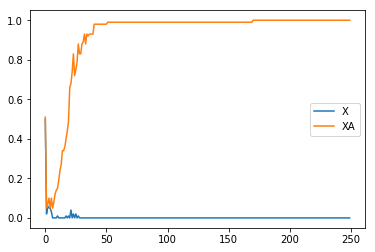

In [23]:
df_final = create_output(df_list, output_file)

Show the plot inline

In [24]:
%matplotlib inline